In [1]:
# Mounting to google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
%cd /content/gdrive/My Drive/ERA - Phase I/Session 8/

/content/gdrive/My Drive/ERA - Phase I/Session 8


# Imports

In [3]:
from model import Net

In [4]:
import utils as utils

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# Dataset, Transforms

In [6]:
device, use_cuda = utils.device()
print(f'CUDA Avialble? {use_cuda}')

CUDA Avialble? True


# Dataset and Creating Train/Test Split

In [7]:
mu = (0.49139968, 0.48215827, 0.44653124)
sigma = (0.24703233, 0.24348505, 0.26158768)

batch_size = 256
kwargs = {'batch_size': batch_size, 'shuffle': True, 'num_workers': 2, 'pin_memory': True}

UnNorm = utils.UnNormalize(mu, sigma)

In [8]:
test_data = utils.Cifar10SearchDataset(root='./data', train=False, download=True, transform=utils.augmentation('Visualization', mu, sigma))
test_loader = torch.utils.data.DataLoader(test_data, **kwargs)

Files already downloaded and verified


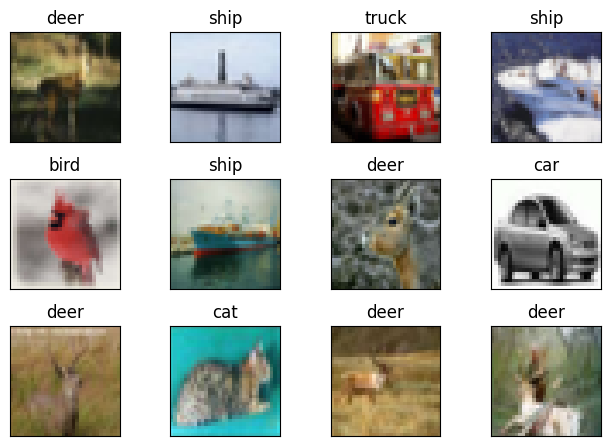

In [9]:
batch_data, batch_label = next(iter(test_loader))
utils.show_examples_dataset_cifar10(batch_data, batch_label)

In [10]:
train_data = utils.Cifar10SearchDataset(root='./data', train=True, download=True, transform=utils.augmentation('Train', mu, sigma))
test_data = utils.Cifar10SearchDataset(root='./data', train=False, download=True, transform=utils.augmentation('Test', mu, sigma))

train_loader = torch.utils.data.DataLoader(train_data, **kwargs)
test_loader = torch.utils.data.DataLoader(test_data, **kwargs)

Files already downloaded and verified
Files already downloaded and verified


# Model

In [11]:
model_BN = Net(n_type='BN').to(device)
utils.show_summary(model_BN, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 30, 30]             432
              ReLU-2           [-1, 16, 30, 30]               0
       BatchNorm2d-3           [-1, 16, 30, 30]              32
            Conv2d-4           [-1, 32, 28, 28]           4,608
              ReLU-5           [-1, 32, 28, 28]               0
       BatchNorm2d-6           [-1, 32, 28, 28]              64
            Conv2d-7           [-1, 16, 28, 28]             512
              ReLU-8           [-1, 16, 28, 28]               0
       BatchNorm2d-9           [-1, 16, 28, 28]              32
        MaxPool2d-10           [-1, 16, 14, 14]               0
           Conv2d-11           [-1, 32, 12, 12]           4,608
             ReLU-12           [-1, 32, 12, 12]               0
      BatchNorm2d-13           [-1, 32, 12, 12]              64
           Conv2d-14           [-1, 32,

In [12]:
model_LN = Net(n_type='LN').to(device)
utils.show_summary(model_LN, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 30, 30]             432
              ReLU-2           [-1, 16, 30, 30]               0
         GroupNorm-3           [-1, 16, 30, 30]              32
            Conv2d-4           [-1, 32, 28, 28]           4,608
              ReLU-5           [-1, 32, 28, 28]               0
         GroupNorm-6           [-1, 32, 28, 28]              64
            Conv2d-7           [-1, 16, 28, 28]             512
              ReLU-8           [-1, 16, 28, 28]               0
         GroupNorm-9           [-1, 16, 28, 28]              32
        MaxPool2d-10           [-1, 16, 14, 14]               0
           Conv2d-11           [-1, 32, 12, 12]           4,608
             ReLU-12           [-1, 32, 12, 12]               0
        GroupNorm-13           [-1, 32, 12, 12]              64
           Conv2d-14           [-1, 32,

In [13]:
model_GN = Net(n_type='GN').to(device)
utils.show_summary(model_GN, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 30, 30]             432
              ReLU-2           [-1, 16, 30, 30]               0
         GroupNorm-3           [-1, 16, 30, 30]              32
            Conv2d-4           [-1, 32, 28, 28]           4,608
              ReLU-5           [-1, 32, 28, 28]               0
         GroupNorm-6           [-1, 32, 28, 28]              64
            Conv2d-7           [-1, 16, 28, 28]             512
              ReLU-8           [-1, 16, 28, 28]               0
         GroupNorm-9           [-1, 16, 28, 28]              32
        MaxPool2d-10           [-1, 16, 14, 14]               0
           Conv2d-11           [-1, 32, 12, 12]           4,608
             ReLU-12           [-1, 32, 12, 12]               0
        GroupNorm-13           [-1, 32, 12, 12]              64
           Conv2d-14           [-1, 32,

# Training

In [14]:
from tqdm import tqdm

def GetCorrectPredCount(pPrediction, pLabels):
  return pPrediction.argmax(dim=1).eq(pLabels).sum().item()

def train(model, device, train_loader, optimizer, criterion):
  model.train()
  pbar = tqdm(train_loader)

  train_loss = 0
  correct = 0
  processed = 0

  for batch_idx, (data, target) in enumerate(pbar):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()

    # Predict
    pred = model(data)

    # Calculate loss
    loss = criterion(pred, target)
    train_loss+=loss.item()

    # Backpropagation
    loss.backward()
    optimizer.step()

    correct += GetCorrectPredCount(pred, target)
    processed += len(data)

    pbar.set_description(desc= f'Train: Loss={loss.item():0.4f} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')

  train_acc = 100*correct/processed

  return train_loss/len(train_loader), train_acc

def test(model, device, test_loader, criterion):
    model.eval()

    test_loss = 0
    correct = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)

            output = model(data)
            test_loss += criterion(output, target, reduction='sum').item()  # sum up batch loss

            correct += GetCorrectPredCount(output, target)


    test_loss /= len(test_loader.dataset)
    test_acc = 100. * correct / len(test_loader.dataset)


    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    return test_loss, test_acc


In [15]:
optimizer = optim.SGD(model_BN.parameters(), lr=0.01, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1, verbose=True)

criterion = F.nll_loss
num_epochs = 20

train_losses_BN = []
test_losses_BN = []

train_acc_BN = []
test_acc_BN = []

for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  train_loss, train_acc = train(model_BN, device, train_loader, optimizer, criterion)
  test_loss, test_acc = test(model_BN, device, test_loader, criterion)

  train_losses_BN.append(train_loss)
  test_losses_BN.append(test_loss)

  train_acc_BN.append(train_acc)
  test_acc_BN.append(test_acc)

  scheduler.step()

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 1


Train: Loss=1.5744 Batch_id=195 Accuracy=33.57: 100%|██████████| 196/196 [00:10<00:00, 18.67it/s]


Test set: Average loss: 1.4579, Accuracy: 4814/10000 (48.14%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 2


Train: Loss=1.4240 Batch_id=195 Accuracy=44.63: 100%|██████████| 196/196 [00:08<00:00, 22.27it/s]


Test set: Average loss: 1.2358, Accuracy: 5584/10000 (55.84%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 3


Train: Loss=1.5317 Batch_id=195 Accuracy=48.72: 100%|██████████| 196/196 [00:10<00:00, 19.01it/s]


Test set: Average loss: 1.1210, Accuracy: 6002/10000 (60.02%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 4


Train: Loss=1.3607 Batch_id=195 Accuracy=51.48: 100%|██████████| 196/196 [00:10<00:00, 18.84it/s]


Test set: Average loss: 1.1242, Accuracy: 5922/10000 (59.22%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 5


Train: Loss=1.2602 Batch_id=195 Accuracy=53.02: 100%|██████████| 196/196 [00:09<00:00, 21.47it/s]


Test set: Average loss: 1.0358, Accuracy: 6303/10000 (63.03%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 6


Train: Loss=1.2916 Batch_id=195 Accuracy=54.94: 100%|██████████| 196/196 [00:09<00:00, 20.24it/s]


Test set: Average loss: 1.0011, Accuracy: 6449/10000 (64.49%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 7


Train: Loss=1.2045 Batch_id=195 Accuracy=56.28: 100%|██████████| 196/196 [00:10<00:00, 18.78it/s]


Test set: Average loss: 0.9129, Accuracy: 6814/10000 (68.14%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 8


Train: Loss=1.3049 Batch_id=195 Accuracy=57.72: 100%|██████████| 196/196 [00:10<00:00, 18.94it/s]


Test set: Average loss: 0.9135, Accuracy: 6769/10000 (67.69%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 9


Train: Loss=1.0460 Batch_id=195 Accuracy=58.99: 100%|██████████| 196/196 [00:09<00:00, 21.50it/s]


Test set: Average loss: 0.8774, Accuracy: 6900/10000 (69.00%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 10


Train: Loss=1.1995 Batch_id=195 Accuracy=59.68: 100%|██████████| 196/196 [00:09<00:00, 21.32it/s]


Test set: Average loss: 0.8567, Accuracy: 6992/10000 (69.92%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 11


Train: Loss=1.1700 Batch_id=195 Accuracy=60.04: 100%|██████████| 196/196 [00:10<00:00, 19.25it/s]


Test set: Average loss: 0.8267, Accuracy: 7136/10000 (71.36%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 12


Train: Loss=0.9520 Batch_id=195 Accuracy=60.82: 100%|██████████| 196/196 [00:10<00:00, 18.98it/s]


Test set: Average loss: 0.7901, Accuracy: 7249/10000 (72.49%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 13


Train: Loss=0.8323 Batch_id=195 Accuracy=61.10: 100%|██████████| 196/196 [00:08<00:00, 22.41it/s]


Test set: Average loss: 0.7937, Accuracy: 7236/10000 (72.36%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 14


Train: Loss=1.0651 Batch_id=195 Accuracy=61.89: 100%|██████████| 196/196 [00:09<00:00, 20.40it/s]


Test set: Average loss: 0.7715, Accuracy: 7328/10000 (73.28%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 15


Train: Loss=0.8381 Batch_id=195 Accuracy=62.24: 100%|██████████| 196/196 [00:12<00:00, 16.10it/s]


Test set: Average loss: 0.7651, Accuracy: 7399/10000 (73.99%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 16


Train: Loss=1.0629 Batch_id=195 Accuracy=63.81: 100%|██████████| 196/196 [00:10<00:00, 19.12it/s]


Test set: Average loss: 0.7155, Accuracy: 7534/10000 (75.34%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 17


Train: Loss=1.0607 Batch_id=195 Accuracy=65.00: 100%|██████████| 196/196 [00:08<00:00, 22.57it/s]


Test set: Average loss: 0.7136, Accuracy: 7532/10000 (75.32%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 18


Train: Loss=0.8088 Batch_id=195 Accuracy=64.99: 100%|██████████| 196/196 [00:10<00:00, 19.47it/s]


Test set: Average loss: 0.7123, Accuracy: 7526/10000 (75.26%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 19


Train: Loss=0.9302 Batch_id=195 Accuracy=65.15: 100%|██████████| 196/196 [00:10<00:00, 19.29it/s]


Test set: Average loss: 0.7053, Accuracy: 7558/10000 (75.58%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 20


Train: Loss=0.9570 Batch_id=195 Accuracy=65.12: 100%|██████████| 196/196 [00:09<00:00, 20.26it/s]


Test set: Average loss: 0.7015, Accuracy: 7564/10000 (75.64%)

Adjusting learning rate of group 0 to 1.0000e-03.


In [16]:
optimizer = optim.SGD(model_LN.parameters(), lr=0.01, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1, verbose=True)

criterion = F.nll_loss
num_epochs = 20

train_losses_LN = []
test_losses_LN = []

train_acc_LN = []
test_acc_LN = []

for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  train_loss, train_acc = train(model_LN, device, train_loader, optimizer, criterion)
  test_loss, test_acc = test(model_LN, device, test_loader, criterion)

  train_losses_LN.append(train_loss)
  test_losses_LN.append(test_loss)

  train_acc_LN.append(train_acc)
  test_acc_LN.append(test_acc)

  scheduler.step()

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 1


Train: Loss=1.8196 Batch_id=195 Accuracy=25.94: 100%|██████████| 196/196 [00:08<00:00, 22.58it/s]


Test set: Average loss: 1.6451, Accuracy: 3940/10000 (39.40%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 2


Train: Loss=1.7116 Batch_id=195 Accuracy=36.88: 100%|██████████| 196/196 [00:10<00:00, 19.15it/s]


Test set: Average loss: 1.4879, Accuracy: 4562/10000 (45.62%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 3


Train: Loss=1.5666 Batch_id=195 Accuracy=42.67: 100%|██████████| 196/196 [00:10<00:00, 19.08it/s]


Test set: Average loss: 1.2830, Accuracy: 5317/10000 (53.17%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 4


Train: Loss=1.3527 Batch_id=195 Accuracy=46.47: 100%|██████████| 196/196 [00:09<00:00, 20.29it/s]


Test set: Average loss: 1.1749, Accuracy: 5796/10000 (57.96%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 5


Train: Loss=1.3576 Batch_id=195 Accuracy=49.46: 100%|██████████| 196/196 [00:08<00:00, 22.25it/s]


Test set: Average loss: 1.1134, Accuracy: 6021/10000 (60.21%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 6


Train: Loss=1.2986 Batch_id=195 Accuracy=51.63: 100%|██████████| 196/196 [00:10<00:00, 18.90it/s]


Test set: Average loss: 1.0375, Accuracy: 6337/10000 (63.37%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 7


Train: Loss=1.2451 Batch_id=195 Accuracy=53.25: 100%|██████████| 196/196 [00:10<00:00, 18.97it/s]


Test set: Average loss: 1.0159, Accuracy: 6400/10000 (64.00%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 8


Train: Loss=1.3859 Batch_id=195 Accuracy=54.23: 100%|██████████| 196/196 [00:10<00:00, 18.82it/s]


Test set: Average loss: 0.9652, Accuracy: 6652/10000 (66.52%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 9


Train: Loss=1.2251 Batch_id=195 Accuracy=56.12: 100%|██████████| 196/196 [00:08<00:00, 22.35it/s]


Test set: Average loss: 0.9505, Accuracy: 6636/10000 (66.36%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 10


Train: Loss=1.2041 Batch_id=195 Accuracy=56.88: 100%|██████████| 196/196 [00:10<00:00, 18.66it/s]


Test set: Average loss: 0.9348, Accuracy: 6691/10000 (66.91%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 11


Train: Loss=1.1349 Batch_id=195 Accuracy=57.48: 100%|██████████| 196/196 [00:10<00:00, 18.59it/s]


Test set: Average loss: 0.9017, Accuracy: 6836/10000 (68.36%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 12


Train: Loss=1.3611 Batch_id=195 Accuracy=58.89: 100%|██████████| 196/196 [00:10<00:00, 18.95it/s]


Test set: Average loss: 0.9037, Accuracy: 6826/10000 (68.26%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 13


Train: Loss=1.2370 Batch_id=195 Accuracy=59.06: 100%|██████████| 196/196 [00:08<00:00, 22.23it/s]


Test set: Average loss: 0.8525, Accuracy: 7030/10000 (70.30%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 14


Train: Loss=1.1410 Batch_id=195 Accuracy=59.60: 100%|██████████| 196/196 [00:10<00:00, 18.03it/s]


Test set: Average loss: 0.8314, Accuracy: 7115/10000 (71.15%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 15


Train: Loss=1.1658 Batch_id=195 Accuracy=60.40: 100%|██████████| 196/196 [00:10<00:00, 18.08it/s]


Test set: Average loss: 0.8180, Accuracy: 7202/10000 (72.02%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 16


Train: Loss=1.1313 Batch_id=195 Accuracy=62.48: 100%|██████████| 196/196 [00:10<00:00, 18.00it/s]


Test set: Average loss: 0.7724, Accuracy: 7364/10000 (73.64%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 17


Train: Loss=1.2829 Batch_id=195 Accuracy=62.75: 100%|██████████| 196/196 [00:11<00:00, 17.71it/s]


Test set: Average loss: 0.7772, Accuracy: 7334/10000 (73.34%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 18


Train: Loss=1.0021 Batch_id=195 Accuracy=63.29: 100%|██████████| 196/196 [00:09<00:00, 20.94it/s]


Test set: Average loss: 0.7659, Accuracy: 7354/10000 (73.54%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 19


Train: Loss=1.1313 Batch_id=195 Accuracy=63.12: 100%|██████████| 196/196 [00:10<00:00, 18.80it/s]


Test set: Average loss: 0.7594, Accuracy: 7370/10000 (73.70%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 20


Train: Loss=1.4127 Batch_id=195 Accuracy=63.40: 100%|██████████| 196/196 [00:10<00:00, 18.46it/s]


Test set: Average loss: 0.7538, Accuracy: 7408/10000 (74.08%)

Adjusting learning rate of group 0 to 1.0000e-03.


In [17]:
optimizer = optim.SGD(model_GN.parameters(), lr=0.01, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1, verbose=True)

criterion = F.nll_loss
num_epochs = 20

train_losses_GN = []
test_losses_GN = []

train_acc_GN = []
test_acc_GN = []

for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  train_loss, train_acc = train(model_GN, device, train_loader, optimizer, criterion)
  test_loss, test_acc = test(model_GN, device, test_loader, criterion)

  train_losses_GN.append(train_loss)
  test_losses_GN.append(test_loss)

  train_acc_GN.append(train_acc)
  test_acc_GN.append(test_acc)

  scheduler.step()

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 1


Train: Loss=1.6847 Batch_id=195 Accuracy=28.32: 100%|██████████| 196/196 [00:09<00:00, 21.31it/s]


Test set: Average loss: 1.5782, Accuracy: 4323/10000 (43.23%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 2


Train: Loss=1.6040 Batch_id=195 Accuracy=38.68: 100%|██████████| 196/196 [00:09<00:00, 20.74it/s]


Test set: Average loss: 1.4384, Accuracy: 4733/10000 (47.33%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 3


Train: Loss=1.6608 Batch_id=195 Accuracy=43.21: 100%|██████████| 196/196 [00:10<00:00, 18.93it/s]


Test set: Average loss: 1.2932, Accuracy: 5328/10000 (53.28%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 4


Train: Loss=1.5323 Batch_id=195 Accuracy=46.38: 100%|██████████| 196/196 [00:10<00:00, 19.04it/s]


Test set: Average loss: 1.1884, Accuracy: 5691/10000 (56.91%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 5


Train: Loss=1.2783 Batch_id=195 Accuracy=48.82: 100%|██████████| 196/196 [00:09<00:00, 21.34it/s]


Test set: Average loss: 1.0954, Accuracy: 6120/10000 (61.20%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 6


Train: Loss=1.3126 Batch_id=195 Accuracy=51.33: 100%|██████████| 196/196 [00:09<00:00, 20.66it/s]


Test set: Average loss: 1.0826, Accuracy: 6123/10000 (61.23%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 7


Train: Loss=1.0988 Batch_id=195 Accuracy=52.79: 100%|██████████| 196/196 [00:10<00:00, 18.39it/s]


Test set: Average loss: 1.0251, Accuracy: 6432/10000 (64.32%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 8


Train: Loss=1.2579 Batch_id=195 Accuracy=53.97: 100%|██████████| 196/196 [00:10<00:00, 18.63it/s]


Test set: Average loss: 1.0246, Accuracy: 6313/10000 (63.13%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 9


Train: Loss=1.1477 Batch_id=195 Accuracy=55.17: 100%|██████████| 196/196 [00:09<00:00, 21.03it/s]


Test set: Average loss: 0.9598, Accuracy: 6659/10000 (66.59%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 10


Train: Loss=1.1398 Batch_id=195 Accuracy=56.39: 100%|██████████| 196/196 [00:09<00:00, 21.47it/s]


Test set: Average loss: 0.9013, Accuracy: 6863/10000 (68.63%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 11


Train: Loss=1.1232 Batch_id=195 Accuracy=57.16: 100%|██████████| 196/196 [00:10<00:00, 18.68it/s]


Test set: Average loss: 0.9118, Accuracy: 6803/10000 (68.03%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 12


Train: Loss=0.9570 Batch_id=195 Accuracy=57.80: 100%|██████████| 196/196 [00:10<00:00, 18.81it/s]


Test set: Average loss: 0.8782, Accuracy: 6952/10000 (69.52%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 13


Train: Loss=1.2644 Batch_id=195 Accuracy=58.33: 100%|██████████| 196/196 [00:09<00:00, 21.13it/s]


Test set: Average loss: 0.9031, Accuracy: 6837/10000 (68.37%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 14


Train: Loss=1.3434 Batch_id=195 Accuracy=59.15: 100%|██████████| 196/196 [00:09<00:00, 20.97it/s]


Test set: Average loss: 0.8645, Accuracy: 6962/10000 (69.62%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 15


Train: Loss=1.1405 Batch_id=195 Accuracy=59.67: 100%|██████████| 196/196 [00:10<00:00, 18.80it/s]


Test set: Average loss: 0.8566, Accuracy: 7002/10000 (70.02%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 16


Train: Loss=1.0094 Batch_id=195 Accuracy=61.22: 100%|██████████| 196/196 [00:10<00:00, 18.73it/s]


Test set: Average loss: 0.8035, Accuracy: 7207/10000 (72.07%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 17


Train: Loss=1.0261 Batch_id=195 Accuracy=61.88: 100%|██████████| 196/196 [00:09<00:00, 20.69it/s]


Test set: Average loss: 0.8028, Accuracy: 7193/10000 (71.93%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 18


Train: Loss=0.9940 Batch_id=195 Accuracy=62.24: 100%|██████████| 196/196 [00:09<00:00, 21.66it/s]


Test set: Average loss: 0.7946, Accuracy: 7219/10000 (72.19%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 19


Train: Loss=1.0376 Batch_id=195 Accuracy=62.24: 100%|██████████| 196/196 [00:12<00:00, 15.68it/s]


Test set: Average loss: 0.7920, Accuracy: 7229/10000 (72.29%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 20


Train: Loss=0.9341 Batch_id=195 Accuracy=62.33: 100%|██████████| 196/196 [00:10<00:00, 18.51it/s]


Test set: Average loss: 0.7968, Accuracy: 7209/10000 (72.09%)

Adjusting learning rate of group 0 to 1.0000e-03.


# Results

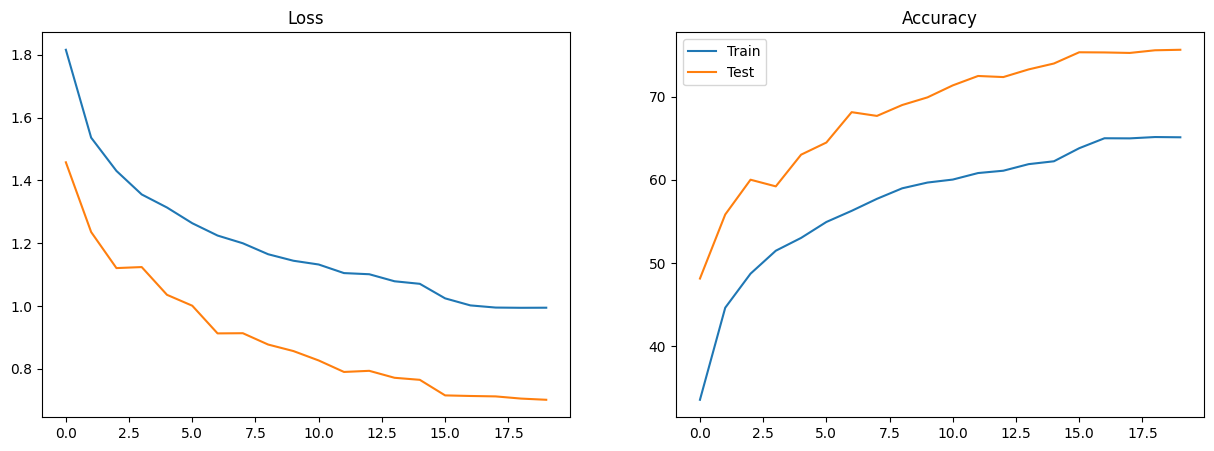

In [18]:
utils.plot_loss_accuracy([train_losses_BN, test_losses_BN, train_acc_BN, test_acc_BN], 'results/Loss_BN.png')

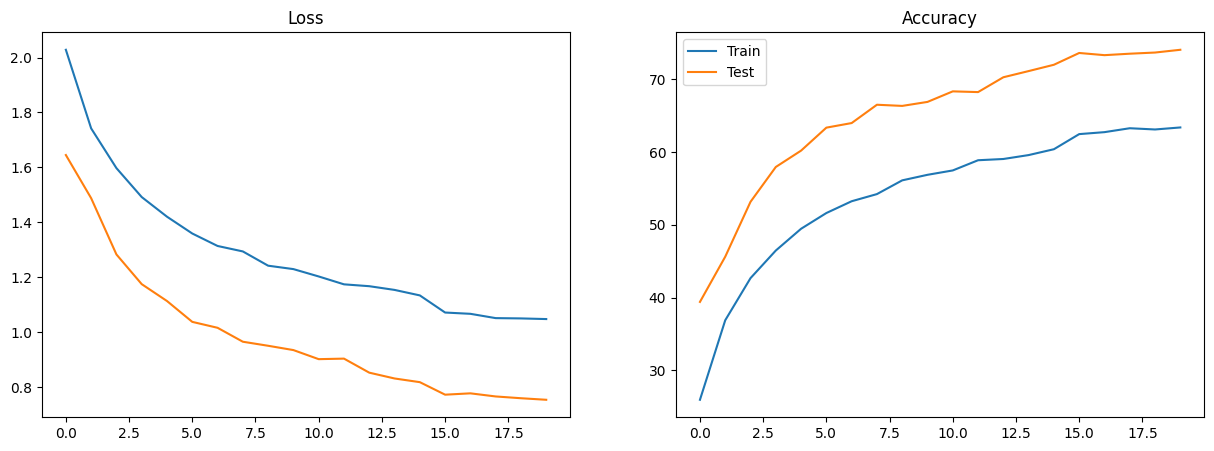

In [19]:
utils.plot_loss_accuracy([train_losses_LN, test_losses_LN, train_acc_LN, test_acc_LN], 'results/Loss_LN.png')

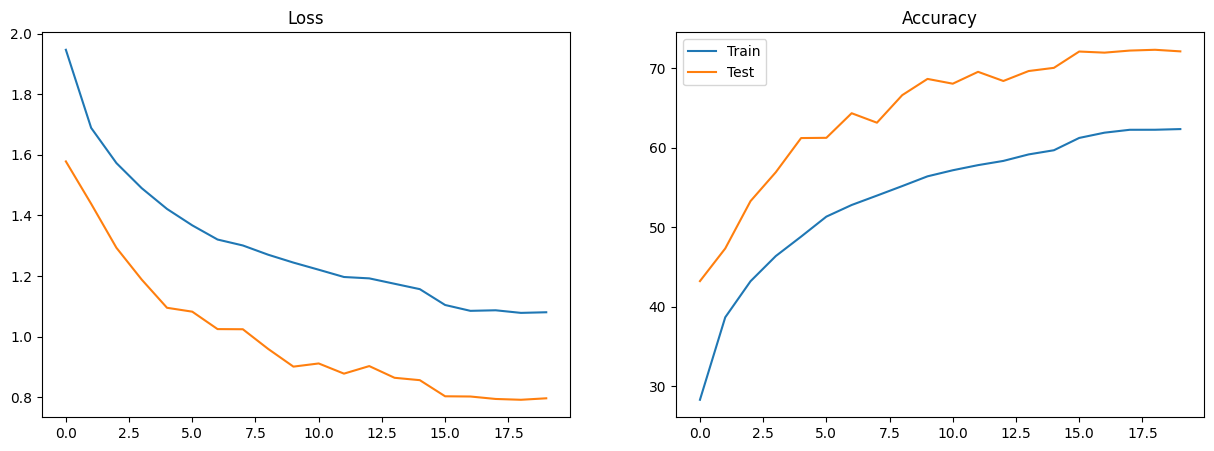

In [20]:
utils.plot_loss_accuracy([train_losses_GN, test_losses_GN, train_acc_GN, test_acc_GN], 'results/Loss_GN.png')

# Mis-classified cases


In [21]:
test_images = [item[0] for item in test_loader.dataset]
test_images = torch.stack(test_images)
test_targets = torch.tensor(test_loader.dataset.targets).to(device)

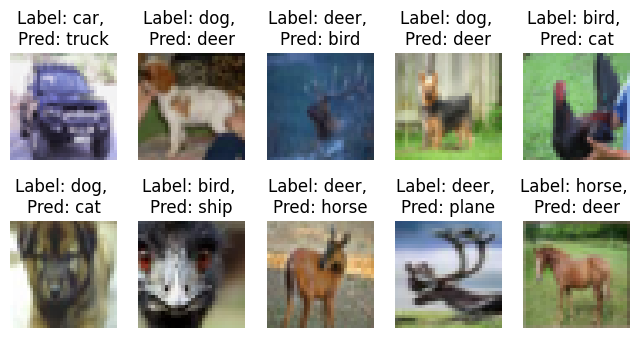

In [22]:
test_predictions = model_BN(test_images.to(device))
wrong = utils.classfication_result(test_predictions, test_targets, device, b=False).cpu()

utils.plot_grid(test_images[wrong], test_targets[wrong], UnNorm, test_predictions[wrong],'results/BN_misclassified.png')

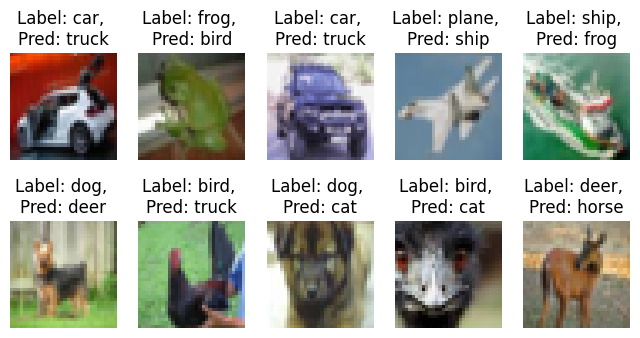

In [23]:
test_predictions = model_LN(test_images.to(device))
wrong = utils.classfication_result(test_predictions, test_targets, device, b=False).cpu()

utils.plot_grid(test_images[wrong], test_targets[wrong], UnNorm, test_predictions[wrong],'results/LN_misclassified.png')

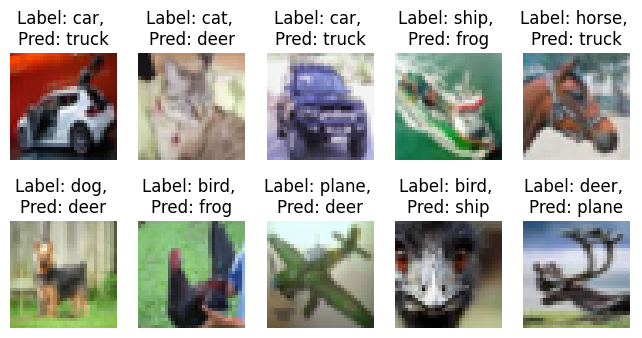

In [24]:
test_predictions = model_GN(test_images.to(device))
wrong = utils.classfication_result(test_predictions, test_targets, device, b=False).cpu()

utils.plot_grid(test_images[wrong], test_targets[wrong], UnNorm, test_predictions[wrong],'results/GN_misclassified.png')